In [3]:
import sys
sys.path.insert(0,'..')
from datetime import datetime
import numpy as np
import pandas as pd
import queryrunner_client as Client 
from scipy.stats import ttest_ind, norm, t

#from helpers import query_runner as qru
#from xp_delta_utils import *

qr = Client.Client(user_email='guoyu.zhu@uber.com')
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

### Execute query

In [4]:
settings = {
    'run_date': datetime.today().strftime('%Y-%m-%d'),
    'sql_file': 'avs_xp.sql',
    'sql_params': {'start_date': '2021-04-13',
                   'end_date': '2021-05-14'
                  }
}
print(settings)

{'sql_file': 'avs_xp.sql', 'run_date': '2021-05-23', 'sql_params': {'start_date': '2021-04-13', 'end_date': '2021-05-14'}}


In [9]:
data_query = """
select date_trunc('month', date(datestr)) as mon_bg_dt 
, marketplace 
, trip_status 
, mega_region 
, cg_tag 
, rider_risk_user_segment_name
 ,sum(-amount_usd) as gb_amt 
 ,sum(case when chargeback_count = 1 then -amount_usd else 0 end) cb_amt 
 ,sum(case when unsettled_count = 1 then -amount_usd else null end) as dns_amt 
from fraud.pmt_risk_cohort_fact 
where datestr >= '{st_ds}' and datestr <'{ed_ds}'
group by 1,2,3,4,5,6
""".format(st_ds='2021-04-01', ed_ds='2021-05-01')

cursor = qr.execute('presto', data_query, pii=True)

05/23/2021 08:43:44 PM  You're using Queryrunner V2! 
05/23/2021 08:43:44 PM  [Polling] 603f2ef8-c2ab-496b-a718-bb8866048cde 
05/23/2021 08:43:44 PM  [Status] created 
05/23/2021 08:43:45 PM  [Status] started waiting to execute 
05/23/2021 08:43:53 PM  [Status] started execution 
05/23/2021 08:44:16 PM  [Status] completed success 
05/23/2021 08:44:16 PM  [Query Success] completed success 


In [10]:
df = pd.DataFrame(cursor.fetchall())

In [11]:
df.shape

(425, 9)

In [12]:
df.head()

,cb_amt,cg_tag,dns_amt,gb_amt,marketplace,mega_region,mon_bg_dt,rider_risk_user_segment_name,trip_status
0,69.122529,NON-CG,26671.748035,131319.913293,personal_transport,LatAm,2021-04-01,new,rider_canceled
1,10.051903,NON-CG,NaN,7149.424893,eats,LatAm,2021-04-01,super_new,unfulfilled
2,0.000000,CG,23.890000,2553.662654,eats,US & Canada,2021-04-01,power,failed
3,0.000000,NON-CG,150.551809,167.482514,eats,EMEA,2021-04-01,vip,canceled
4,8.785802,CG,180.713055,689.212723,personal_transport,LatAm,2021-04-01,super_new,rider_canceled


In [13]:
df.groupby('marketplace').agg(['mean','std'])

cb_amt                      dns_amt                 \
                            mean            std          mean            std   
marketplace                                                                    
cornershop           3621.145639   10612.234808  25701.904764   65092.930491   
eats                22559.579839  164804.870205  58654.974731  169103.342214   
emobility             425.294707     619.564451   4637.839551    5526.201871   
financial_product   11277.545716   15709.860436           NaN            NaN   
personal_transport  10160.220518   58894.615145  66544.715171  197735.774434   

                          gb_amt                
                            mean           std  
marketplace                                     
cornershop          6.003614e+05  2.225857e+06  
eats                1.818016e+07  1.224136e+08  
emobility           5.345522e+05  5.356216e+05  
financial_product   3.959420e+06  6.602706e+06  
personal_transport  1.466627e+07  9.006299e+07

### Save file in the dataFrame

In [ ]:
import pandas as pd
df.to_pickle('123.pkl')    #to save the dataframe, df to 123.pkl
df1 = pd.read_pickle('123.pkl') #to load 123.pkl back to the dataframe df

In [16]:
df['loss_rate'] = (df['cb_amt']+df['dns_amt'])/df['gb_amt']

In [23]:
df['cb_rate'] = df['cb_amt']/df['gb_amt']
df['dns_rate'] = df['dns_amt']/df['gb_amt']

In [24]:
df.head()

,cb_amt,cg_tag,dns_amt,gb_amt,marketplace,mega_region,mon_bg_dt,rider_risk_user_segment_name,trip_status,loss_rate,cb_rate,dns_rate
0,69.122529,NON-CG,26671.748035,131319.913293,personal_transport,LatAm,2021-04-01,new,rider_canceled,0.203631,0.000526,0.203105
2,0.000000,CG,23.890000,2553.662654,eats,US & Canada,2021-04-01,power,failed,0.009355,0.000000,0.009355
3,0.000000,NON-CG,150.551809,167.482514,eats,EMEA,2021-04-01,vip,canceled,0.898911,0.000000,0.898911
4,8.785802,CG,180.713055,689.212723,personal_transport,LatAm,2021-04-01,super_new,rider_canceled,0.274950,0.012748,0.262202
5,95.106554,NON-CG,12090.701833,73061.931235,personal_transport,APAC,2021-04-01,new,rider_canceled,0.166787,0.001302,0.165486


In [25]:
df = df.dropna()
df.head()

,cb_amt,cg_tag,dns_amt,gb_amt,marketplace,mega_region,mon_bg_dt,rider_risk_user_segment_name,trip_status,loss_rate,cb_rate,dns_rate
0,69.122529,NON-CG,26671.748035,131319.913293,personal_transport,LatAm,2021-04-01,new,rider_canceled,0.203631,0.000526,0.203105
2,0.000000,CG,23.890000,2553.662654,eats,US & Canada,2021-04-01,power,failed,0.009355,0.000000,0.009355
3,0.000000,NON-CG,150.551809,167.482514,eats,EMEA,2021-04-01,vip,canceled,0.898911,0.000000,0.898911
4,8.785802,CG,180.713055,689.212723,personal_transport,LatAm,2021-04-01,super_new,rider_canceled,0.274950,0.012748,0.262202
5,95.106554,NON-CG,12090.701833,73061.931235,personal_transport,APAC,2021-04-01,new,rider_canceled,0.166787,0.001302,0.165486


In [27]:
df.groupby('cg_tag').agg(['mean','std'])[['loss_rate','cb_rate','dns_rate']]

loss_rate             cb_rate           dns_rate          
            mean       std      mean      std      mean       std
cg_tag                                                           
CG      0.186858  0.268730  0.003348  0.01524  0.183511  0.269848
NON-CG  0.172950  0.276435  0.002947  0.00594  0.170003  0.277418

### Two samples  Proportion metrics
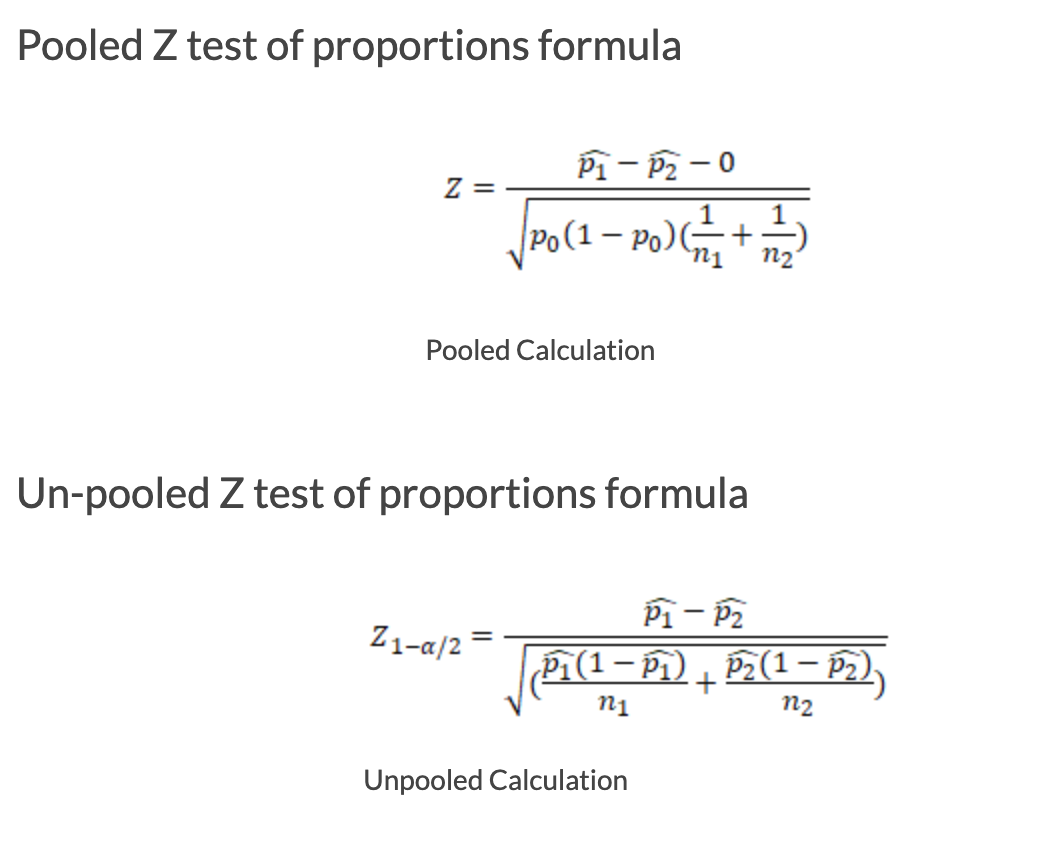

In [14]:
def two_samples_prop_test(metric_name, treat_col, control_col, pooled=True):
    """ 
    Two indep samples proportion test (z-test). 
    To check for treatment and control (p=pooled proportion, n is specific per group): 
    n > 10 and n * p > 10
    """
    # for each group get size and mean
    n_treat = len(treat_col)
    treat_mean = treat_col.mean()
    
    n_control = len(control_col)
    control_mean = control_col.mean()
    
    # mean of estimator
    estim_mean = treat_mean - control_mean
    
    # get standard error of estimator
    if pooled: 
        pooled_mean = (n_control * control_mean + n_treat * treat_mean)/ (n_treat + n_control)
        std_error = np.sqrt(pooled_mean * (1-pooled_mean) *(1 / n_treat + 1 / n_control))
    else:
        std_error = np.sqrt(treat_mean * (1-treat_mean) / n_treat + control_mean * (1-control_mean) / n_control)
    
    # z-test
    z_val = estim_mean / std_error
    p_val = 2 * norm.cdf(-abs(z_val))
    
    # confidence interval (95%)
    ci_lower = estim_mean - 1.96 * std_error
    ci_upper = estim_mean + 1.96 * std_error
    
    return {'metric': metric_name, 'z_score': z_val,
            'pvalue': p_val, 'control': control_mean, 'treatment': treat_mean,
            'relative_diff': treat_mean/control_mean - 1.0, 'abs_diff': treat_mean - control_mean,
            'ci_lower': ci_lower, 'ci_upper': ci_upper}

In [28]:
results_prop = pd.DataFrame([])
prop_metrics = ['loss_rate','cb_rate','dns_rate']

In [30]:
for metric_name in prop_metrics: 
    results_prop = results_prop.append(two_samples_prop_test(metric_name=metric_name, 
                      treat_col=df.loc[df['cg_tag'] == 'NON-CG', metric_name], 
                      control_col=df.loc[df['cg_tag'] == 'CG', metric_name], 
                      pooled=False
                     )
                  , ignore_index=True)
results_prop[['metric', 
              'control', 
              'treatment',
              'relative_diff', 
              'abs_diff',
              'ci_lower',
              'ci_upper', 
              'z_score',
              'pvalue']]

,metric,control,treatment,relative_diff,abs_diff,ci_lower,ci_upper,z_score,pvalue
0,loss_rate,0.186858,0.172950,-0.074433,-0.013908,-0.115710,0.087893,-0.267782,0.788867
1,cb_rate,0.003348,0.002947,-0.119846,-0.000401,-0.015264,0.014462,-0.052910,0.957804
2,dns_rate,0.183511,0.170003,-0.073605,-0.013507,-0.114608,0.087594,-0.261859,0.793430


### Continuous metrics
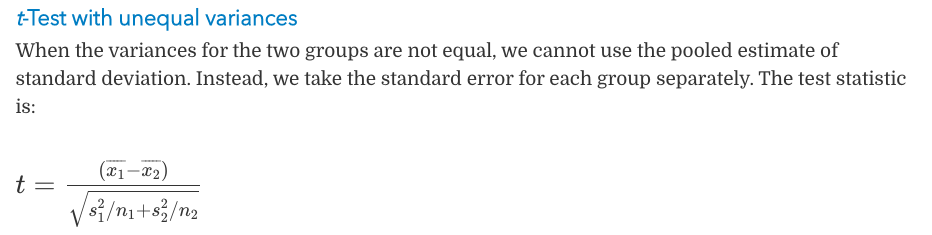

In [35]:
results_cont = pd.DataFrame([])
cont_metrics =['cb_amt','dns_amt','gb_amt']

In [36]:
for metric_name in cont_metrics:
    treat_col = df.loc[df['cg_tag'] == 'NON-CG', metric_name]
    control_col = df.loc[df['cg_tag'] == 'CG', metric_name]
    
    control_mean = control_col.mean()
    treat_mean = treat_col.mean()
    
    control_std = control_col.std()
    
    t_stat, pvalue = ttest_ind(treat_col, control_col, equal_var=False)
    
    results_cont = results_cont.append({'metric': metric_name, 't_stat': t_stat,
            'pvalue': pvalue, 'control': control_mean, 'control_std': control_std, 'treatment': treat_mean,
           'relative_diff': treat_mean/control_mean - 1.0, 'abs_diff': treat_mean - control_mean}, 
                       ignore_index=True)
results_cont[['metric', 
              'control_std',
              'control', 
              'treatment', 
              'relative_diff', 
              'abs_diff', 
              't_stat', 
              'pvalue']]

,metric,control_std,control,treatment,relative_diff,abs_diff,t_stat,pvalue
0,cb_amt,780.062533,219.018315,5.457953e+04,248.200769,5.436051e+04,2.597941,1.059406e-02
1,dns_amt,4159.504773,1988.132979,1.408580e+05,69.849395,1.388699e+05,5.810579,5.559894e-08
2,gb_amt,532097.032602,162874.840570,5.355454e+07,327.807939,5.339167e+07,3.018911,3.119841e-03
